In [2]:
import pandas as pd
import numpy as np
import yaml
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from scipy.fft import fft
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler, PowerTransformer, RobustScaler
from sklearn.linear_model import LinearRegression
import openpyxl
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score,precision_score, f1_score, mean_squared_error
import xgboost as xgb
import optuna
import talib
import json
import pickle
import torch
import os
import logging
from scipy.stats.mstats import winsorize
from plotly.subplots import make_subplots
import seaborn as sns
from imblearn.over_sampling import SMOTEN
import smogn
import warnings
from datetime import datetime, timedelta

In [3]:
print(torch.backends.mps.is_available())

True


In [4]:
def load_yaml(file):
    import yaml
    with open(file, 'r') as f:
        config = yaml.safe_load(f)
    return config
    



In [5]:
config = load_yaml('../config_xgRegSlope.yaml')

In [6]:
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

log_dir = "logs"
os.makedirs(log_dir, exist_ok=True)
log_file = "logstraining_logs_xgRegSlope.txt"
log_file_path = os.path.join(log_dir, log_file)
print(log_file_path)
logging.basicConfig(
    filename=log_file_path,
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S"
)

logging.info("Logging started")

logs/logstraining_logs_xgRegSlope.txt


In [7]:
all_trading_data_dfs = []
sheet_names = ['5minData11-6-2014', '5minData12-17-2019']
for sheet in sheet_names:
    temp_df = pd.read_excel(config['all_data_excel_path'], sheet_name=sheet)
    all_trading_data_dfs.append(temp_df)
all_trading_data = pd.concat(all_trading_data_dfs, ignore_index=True)

# Load 5 min data
all_trading_data['Date'] = pd.to_datetime(all_trading_data['Date'])

In [8]:
##### Set the Date Start and End for the filtering of trading data
train_start_date = pd.to_datetime('2023-01-01')
train_end_date = pd.to_datetime('2023-12-31')
trading_data_raw = all_trading_data[(all_trading_data['Date'] >= train_start_date) & (all_trading_data['Date'] <= train_end_date)]
trading_data_raw = trading_data_raw.reset_index(drop=True)
trading_data_raw.drop(columns=['Symbol'], inplace=True)
trading_data_raw.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19430 entries, 0 to 19429
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    19430 non-null  datetime64[ns]
 1   Open    19430 non-null  float64       
 2   High    19430 non-null  float64       
 3   Low     19430 non-null  float64       
 4   Close   19430 non-null  float64       
 5   Volume  19430 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 910.9 KB


In [9]:
fourier_lookback_window = config['fourier_lookback_window']
fourier_n_components = config['fourier_n_components']
m_bars = config['m_future']

In [10]:
def calculate_bollinger_bands(data, window_size, num_std_dev):
    rolling_mean = data['Close'].rolling(window=window_size).mean()
    rolling_std = data['Close'].rolling(window=window_size).std()
    data['BOLLBU'] = rolling_mean + (rolling_std * num_std_dev)
    data['BOLLBM'] = rolling_mean
    data['BOLLBL'] = rolling_mean - (rolling_std * num_std_dev)
    
    return data

def calculate_donchn_bands(data, window_size):
    data['DONCH_U'] = data['High'].rolling(window=window_size).max()
    data['DONCH_L'] = data['Low'].rolling(window=window_size).min()
    
    return data
    
def calculate_tchr(data):
    period = config['tchr_period']
    retracement = config['tchr_retracement']
    adj = config['tchr_adj']
    range = config['tchr_range']

    if range == 'highlow':
        data['TCHR_U'] = talib.MAX(data['High'], timeperiod=period) + adj
        data['TCHR_L'] = talib.MIN(data['Low'], timeperiod=period) - adj
    elif range == 'close':
        data['TCHR_U'] = talib.MAX(data['Close'], timeperiod=period) + adj
        data['TCHR_L'] = talib.MIN(data['Close'], timeperiod=period) - adj
    
    #calculate retracement
    if retracement == "long":
        data['TCHR'] = (data['Close'] - data['TCHR_L']) / (data['TCHR_U'] - data['TCHR_L'])
    elif retracement == "short":
        data['TCHR'] = (data['TCHR_U'] - data['Close']) / (data['TCHR_U'] - data['TCHR_L'])
    
    return data
    
def calculate_adwm(data):
    period = config['adwm_period']
    data['Previous_Close']= data['Close'].shift(1)
    data['TRH'] = data[['High', 'Previous_Close']].max(axis=1)
    data['TRL'] = data[['Low', 'Previous_Close']].min(axis=1)

    data['ADWM_AD'] = 0.0
    data.loc[data['Close'] > data['Previous_Close'], 'ADWM_AD'] = (data['Close'] - data['TRL'])
    data.loc[data['Close'] < data['Previous_Close'], 'ADWM_AD'] = (data['Close'] - data['TRH'])

    data['ADWM'] = data['ADWM_AD']

    data['ADWMMA'] = data['ADWM'].rolling(window=period).mean()

    return data

def calculate_si(row, prev_row, limit):
    if pd.isna(prev_row['Close']):
        return 0
    c = row['Close']
    c_prev = prev_row['Close']
    o = row['Open']
    o_prev = prev_row['Open']
    return (50 * ((c - c_prev) + (0.5 * (c - o)) + (0.25 * (c_prev - o_prev))) / limit)

def calculate_WASI(data):
    wasi_limit = config['wasi_limit']
    data['SI'] = data.apply(lambda row: calculate_si(row, data.shift(1).loc[row.name], wasi_limit), axis=1)
    data['WASI'] = data['SI']
    return data

def calculate_ATR(data):
    atr_period = config['atr_period']
    atr_ma = config['atr_ma']
    data['ATR'] = talib.ATR(data['High'], data['Low'], data['Close'], timeperiod=atr_period)
    data['ADJATR'] = talib.SMA(data['ATR'], timeperiod=atr_ma)
    return data


def compute_volatility_momentum(df, price_col='Close', vol_window=14, mom_window=10):
    """
    Computes rolling volatility and momentum for a given price column.

    Parameters:
        df (pd.DataFrame): DataFrame containing historical price data.
        price_col (str): Column name of the closing price.
        vol_window (int): Window size for rolling volatility calculation.
        mom_window (int): Window size for momentum calculation.

    Returns:
        pd.DataFrame: DataFrame with added 'Volatility' and 'Momentum' features.
    """

    # Ensure price column exists
    if price_col not in df.columns:
        raise ValueError(f"Column '{price_col}' not found in DataFrame")

    # 🔹 Compute Log Returns (for better volatility calculation)
    df['Log_Returns'] = np.log(df[price_col] / df[price_col].shift(1))

    # 🔹 Compute Rolling Volatility (Standard Deviation of Log Returns)
    df['Volatility'] = df['Log_Returns'].rolling(window=vol_window).std()

    # 🔹 Compute Momentum (Rate of Change in Price)
    df['Momentum'] = df[price_col].pct_change(periods=mom_window) * 100

    # 🔹 Drop NaN values from rolling computations
    #df.dropna(inplace=True)

    return df


def compute_fourier_df(value_series, n_components=10):
    fft_result = np.fft.fft(value_series)
    real = fft_result.real[:n_components]
    imag = fft_result.imag[:n_components]
    mag = np.abs(fft_result)[:n_components]

    return real, imag, mag

def get_fourier_columns():
    return [f'fourier_real_{j+2}' for j in range(fourier_n_components-1)] + [f'fourier_imag_{j+2}' for j in range(fourier_n_components-1)] + [f'fourier_mag_{j+2}' for j in range(fourier_n_components-1)]   

def transform_features(df):
    close_diff_features = config['Close_Diff_Features'].split(',')
    df[close_diff_features] = df[close_diff_features].sub(df['Close'], axis=0).div(df['Close'], axis=0)
    return df

def get_all_training_features():
    training_features = config['training_features'].split(',')
    fourier_cols = get_fourier_columns()
    return training_features + fourier_cols

def normalize_timegaps(df, time_gap_threshold=300):
    df = df.copy()
    features = ['Open', 'High', 'Low', 'Close']
    df['time_delta'] = df['Date'].diff().dt.total_seconds()
    df['time_delta'] = df['time_delta'].fillna(df['time_delta'].median())
    df['time_gap_flag'] = df['time_delta'] > time_gap_threshold
    gap_indices = df.index[df['time_gap_flag']].tolist()
    for p in gap_indices:
        if p > 0: # ensure p-1 exist
            jump_value = df.loc[p, 'Close'] - df.loc[p-1, 'Close']
            df.loc[:p-1, features] += jump_value
    return df

In [11]:
def add_new_features_df(data):
    fourier_lookback_window = config['fourier_lookback_window']
    fourier_n_components = config['fourier_n_components']

    #data['Date'] = pd.to_datetime(data['Date'])
    #print(f"bolband period : {config['bolband_period']}")
    bolband_period = config['bolband_period']
    bolband_width = config['bolband_width']
    upper, middle, lower = talib.BBANDS(data['Close'], timeperiod=bolband_period, nbdevup=bolband_width, nbdevdn=bolband_width, matype=0)
    data['BOLLBU'] = upper
    data['BOLLBM'] = middle
    data['BOLLBL'] = lower
    #data = calculate_bollinger_bands(data, int(config['bolband_period']), int(config['bolband_width']))

    # Calculate DONCHN Bands
    donchn_period = config['donchn_period']
    data['DONUP'] = talib.MAX(data['High'], timeperiod=donchn_period)

    data['DONLOW'] = talib.MIN(data['Low'], timeperiod=donchn_period)

    data['DONMID'] = (data['DONLOW'] + data['DONUP']) / 2

    data['MA20'] = talib.SMA(data['Close'], timeperiod=20)

    data['MA50'] = talib.SMA(data['Close'], timeperiod=50)

    data['MA100'] = talib.SMA(data['Close'], timeperiod=100)

    data['EMA20'] = talib.EMA(data['Close'], timeperiod=20)

    # Calculate the pivot points
    data['PVPT'] = (data['High'] + data['Low'] + data['Close']) / 3
    data['PVPTR1'] = (2 * data['PVPT']) - data['Low']

    data['PVPTR2'] = data['PVPT'] + data['High'] - data['Low']

    data['PVPTR3'] = data['High'] + 2 * (data['PVPT'] - data['Low'])

    data['PVPTS1'] = (2 * data['PVPT']) - data['High']

    data['PVPTS2'] = data['PVPT'] - (data['High'] - data['Low'])

    data['PVPTS3'] = data['Low'] - 2 * (data['High'] - data['PVPT'])

    data = calculate_tchr(data)

    data = calculate_adwm(data)

    data = calculate_WASI(data)

    volume_ma_period = config['volume_ma_period']

    data['VOLMA'] = talib.SMA(data['Volume'], timeperiod=volume_ma_period)

    data = calculate_ATR(data)

    data['DayofWeek'] = data['Date'].dt.dayofweek

    data['DayofWeek'] = data['DayofWeek'].astype('category')

    data = compute_volatility_momentum(data, price_col='Close', vol_window=config['volatility_period'], mom_window=config['momentum_period'])

    # Add fourier columns to the df
    for i in range(fourier_n_components):
        data[f'fourier_real_{i+1}'] = np.nan
        data[f'fourier_imag_{i+1}'] = np.nan
        data[f'fourier_mag_{i+1}'] = np.nan

    features = []
    epsilon = 1e-5
    #print(f"fourier window - 1 : {fourier_lookback_window - 1}")
    for i in range(len(data)):
        if i >= fourier_lookback_window - 1:
            #print("entered point 1")
            close_window = data['Close'].iloc[i - fourier_lookback_window + 1: i + 1].values
            real, imag, mag = compute_fourier_df(close_window, n_components=fourier_n_components)

            for j in range(fourier_n_components):
                data.iloc[i, data.columns.get_loc(f'fourier_real_{j+1}')] = real[j]
                data.iloc[i, data.columns.get_loc(f'fourier_imag_{j+1}')] = imag[j]
                data.iloc[i, data.columns.get_loc(f'fourier_mag_{j+1}')] = mag[j]
                #print(data.loc[i, 'Date'])
    


    # Add the time of day feature to the trading data

    # Define max time of day in minutes
    MAX_TIME_MINUTES = 1440
    data['Minutes_Passed'] = (data['Date'].dt.hour* 60) + data['Date'].dt.minute
    data['TimeOfDay_Group'] = (data['Minutes_Passed'] // 5).astype('int')
    data['Sine_TimeOfDay'] = np.sin(2 * np.pi * data['TimeOfDay_Group'] / MAX_TIME_MINUTES)
    data['Cosine_TimeOfDay'] = np.cos(2 * np.pi * data['TimeOfDay_Group'] / MAX_TIME_MINUTES)
    data['Take_Profit_Level'] = (data['Close'] * config['atr_multiplier'] * data['ADJATR'])
    data['time_delta'] = data['Date'].diff().dt.total_seconds()
    data['time_delta'].fillna(data['time_delta'].median(), inplace=True)
    #print("Feature df info : ")
    #print(data.info())

    #print(f"Last row after adding features : ")
    #print(data.tail())
    return data


In [12]:
trading_data_time_normalized = normalize_timegaps(trading_data_raw)

In [13]:
toplot_df = trading_data_time_normalized

fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
                    vertical_spacing=0.1,
                    subplot_titles=("CandleStick Chart Norm", "CandleStick Chart"))
fig.add_trace(
    go.Candlestick(
        x=toplot_df['Date'], 
        open=toplot_df['Open'], 
        high=toplot_df['High'], 
        low=toplot_df['Low'], 
        close=toplot_df['Close'],
        name='OHLC Norm'
        ), row=1, col=1
)

fig.add_trace(
    go.Candlestick(
        x=trading_data_raw['Date'], 
        open=trading_data_raw['Open'], 
        high=trading_data_raw['High'], 
        low=trading_data_raw['Low'], 
        close=trading_data_raw['Close'],
        name='OHLC'
        ), row=2,col=1
)

fig.update_layout(
    title='CandleStick chart of time normalized',
    xaxis=dict(type="date", 
               rangebreaks=[
                   dict(bounds=["sat", "mon"]),
                   dict(bounds=[16,9.5], pattern='hour')
               ]              
            ),
    xaxis_rangeslider_visible=False,
    height=600,
    hovermode='x unified'
)



fig.update_xaxes(matches='x')

fig.show()

In [14]:

def calculate_label(data):

# Define the threshold for buy and sell signals
    
    buy_powers = []
    sell_powers = []
    n=config['bars_no_to_wait']
    for i in range(len(data)):
        current_close = data.loc[i, "Close"]

        future_closes = data.loc[i+1: i+n+1, "Close"].values

        if len(future_closes) == 0:
            buy_powers.append(0)
            sell_powers.append(0)
            continue
        future_close_max = max(future_closes) 
        future_close_min = min(future_closes)
        max_high = future_close_max - current_close
        min_high = current_close - future_close_min
        max_high_idx = list(future_closes).index( future_close_max)
        min_high_idx = list(future_closes).index( future_close_min)

        if max_high_idx == (len(future_closes) - 1): #when max value is at the last of window
            buy_retr_penalty = 0
        else:
            buy_retr_penalty = future_close_max - min(future_closes[max_high_idx+1:])
        max_down_below = max(0, current_close - future_close_min)
        penalty_buy = buy_retr_penalty + max_down_below
        buy_power = max(0, max_high - penalty_buy)

        if min_high_idx == (len(future_closes) - 1): 
            sell_retr_penalty = 0
        else:
            sell_retr_penalty = max(future_closes[min_high_idx+1:]) - future_close_min
        max_up_above = max(0, future_close_max - current_close)
        penalty_sell = sell_retr_penalty + max_up_above
        sell_power = max(0, min_high - penalty_sell)

        buy_powers.append(buy_power)
        sell_powers.append(sell_power)

    data['BuyPower'] = buy_powers
    data['SellPower'] = sell_powers
        

    return data

In [15]:
trading_data_with_power = calculate_label(trading_data_time_normalized)
trading_data_with_power.dropna(inplace=True)

In [16]:
trading_data_with_power[['BuyPower']].describe()

BuyPower
count  19430.000000
mean       0.336215
std        0.643031
min        0.000000
25%        0.000000
50%        0.000000
75%        0.448075
max        9.050000

In [17]:
trading_data_with_power[['SellPower']].describe()

SellPower
count  19430.000000
mean       0.306297
std        0.667021
min        0.000000
25%        0.000000
50%        0.000000
75%        0.278700
max        9.600000

In [18]:
trading_data_with_power[(trading_data_with_power['BuyPower'] > 0.5) | (trading_data_with_power['SellPower'] > 0.5)].count()
#trading_data_with_slope.count()

Date             8481
Open             8481
High             8481
Low              8481
Close            8481
Volume           8481
time_delta       8481
time_gap_flag    8481
BuyPower         8481
SellPower        8481
dtype: int64

In [19]:
trading_data_with_features = add_new_features_df(trading_data_with_power.copy())

/var/folders/ns/6tgyd_dx5lq_3chvzvfdm1sr0000gp/T/ipykernel_39932/1900632745.py:96: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [20]:
pd.set_option("display.max_columns", None)  # Show all columns
pd.set_option("display.max_rows", None)  # Show all rows
trading_data_with_features.describe().T

count                           mean  \
Date                 19430  2023-07-02 15:44:07.936180992   
Open               19430.0                     468.036754   
High               19430.0                     468.267182   
Low                19430.0                     467.801705   
Close              19430.0                     468.039982   
Volume             19430.0                  748430.984354   
time_delta         19430.0                    1602.027792   
BuyPower           19430.0                       0.336215   
SellPower          19430.0                       0.306297   
BOLLBU             19411.0                     469.038549   
BOLLBM             19411.0                     468.057158   
BOLLBL             19411.0                     467.075768   
DONUP              19411.0                     469.093305   
DONLOW             19411.0                     466.954038   
DONMID             19411.0                     468.023672   
MA20               19411.0                     468.057158   
MA50               19381.0                     468.086562   
MA100              19331.0                     468.136237   
EMA20              19411.0                     468.057532   
PVPT               19430.0                     468.036289   
PVPTR1             19430.0                     468.270874   
PVPTR2             19430.0                     468.501766   
PVPTR3             19430.0                     468.736351   
PVPTS1             19430.0                     467.805397   
PVPTS2             19430.0                     467.570813   
PVPTS3             19430.0                     467.339921   
TCHR_U             19331.0                     475.555742   
TCHR_L             19331.0                     460.534923   
TCHR               19331.0                       0.515323   
Previous_Close     19429.0                     468.039603   
TRH                19430.0                     468.267304   
TRL                19430.0                     467.801533   
ADWM_AD            19430.0                       0.005714   
ADWM               19430.0                       0.005714   
ADWMMA             19417.0                       0.005903   
SI                 19430.0                       0.081289   
WASI               19430.0                       0.081289   
VOLMA              19421.0                  747670.370347   
ATR                19416.0                       0.465729   
ADJATR             19397.0                       0.465537   
Log_Returns        19429.0                       0.000005   
Volatility         19416.0                       0.000604   
Momentum           19420.0                       0.005909   
fourier_real_1     19331.0                    46813.62368   
fourier_imag_1     19331.0                            0.0   
fourier_mag_1      19331.0                    46813.62368   
fourier_real_2     19331.0                      -0.185167   
fourier_imag_2     19331.0                       4.326233   
fourier_mag_2      19331.0                       61.55453   
fourier_real_3     19331.0                      -0.128774   
fourier_imag_3     19331.0                       2.168186   
fourier_mag_3      19331.0                      31.372622   
fourier_real_4     19331.0                       -0.13242   
fourier_imag_4     19331.0                       1.435442   
fourier_mag_4      19331.0                      20.245386   
fourier_real_5     19331.0                      -0.135737   
fourier_imag_5     19331.0                       1.079201   
fourier_mag_5      19331.0                      14.764448   
fourier_real_6     19331.0                      -0.137131   
fourier_imag_6     19331.0                       0.859639   
fourier_mag_6      19331.0                       12.21928   
fourier_real_7     19331.0                      -0.135077   
fourier_imag_7     19331.0                        0.71357   
fourier_mag_7      19331.0                      10.181927   
fourier_real_8     19331.0                      -0.13588

In [21]:
#trading_data['Date'] = pd.to_datetime(trading_data['Date'])
fig = go.Figure(data=[go.Candlestick(x=trading_data_with_features['Date'], open=trading_data_with_features['Open'], high=trading_data_with_features['High'], low=trading_data_with_features['Low'], close=trading_data_with_features['Close'])])
fig.update_layout(title='CandleStick Chart SPY', xaxis_title='Date', yaxis_title='Price', xaxis_rangeslider_visible=False, yaxis=dict(fixedrange=False), xaxis=dict(type='category'))
buy_signals = trading_data_with_features[trading_data_with_features['BuyPower'] > 0.5]
sell_signals = trading_data_with_features[trading_data_with_features['SellPower'] > 0.5]
fig.add_trace(go.Scatter(x=buy_signals['Date'], y=buy_signals['Low'], mode='markers', name='Buy Signal', marker=dict(color='blue', size=10), text=[f"Slope: {slope:.3f}" for slope in buy_signals['BuyPower']]))
fig.add_trace(go.Scatter(x=sell_signals['Date'], y=sell_signals['High'], mode='markers', name='Sell Signal', marker=dict(color='yellow', size=10), text=[f"Slope: {slope:.3f}" for slope in sell_signals['SellPower']]))
fig.show()

####  Transform Features that have to be differenced from Close

In [22]:
trading_data_transformed = transform_features(trading_data_with_features.copy())

In [23]:
all_training_features = get_all_training_features()

#### Do Robust scaling on all training features

In [24]:
trading_data_scaled = trading_data_transformed.copy()
rscaler = RobustScaler()
trading_data_scaled[all_training_features] = rscaler.fit_transform(trading_data_scaled[all_training_features])

#### Use Clipping (Winsorization) to Limit Extreme Values

In [25]:
def winsor_features(df, features, lower=5, upper=95):
    df = df.copy()
    lower_limit = lower / 100
    upper_limit = (100 - upper) / 100
    for feature in features:
        df[feature] = winsorize(df[feature], limits=(lower_limit, upper_limit))

    return df

In [26]:
### Set lower limit and upper limit for winsor
lower_limit_winsor = 5
upper_limit_Winsor = 95
### Apply the winsorization for all training features
trading_data_scaled = winsor_features(trading_data_scaled, all_training_features, lower=lower_limit_winsor, upper=upper_limit_Winsor)



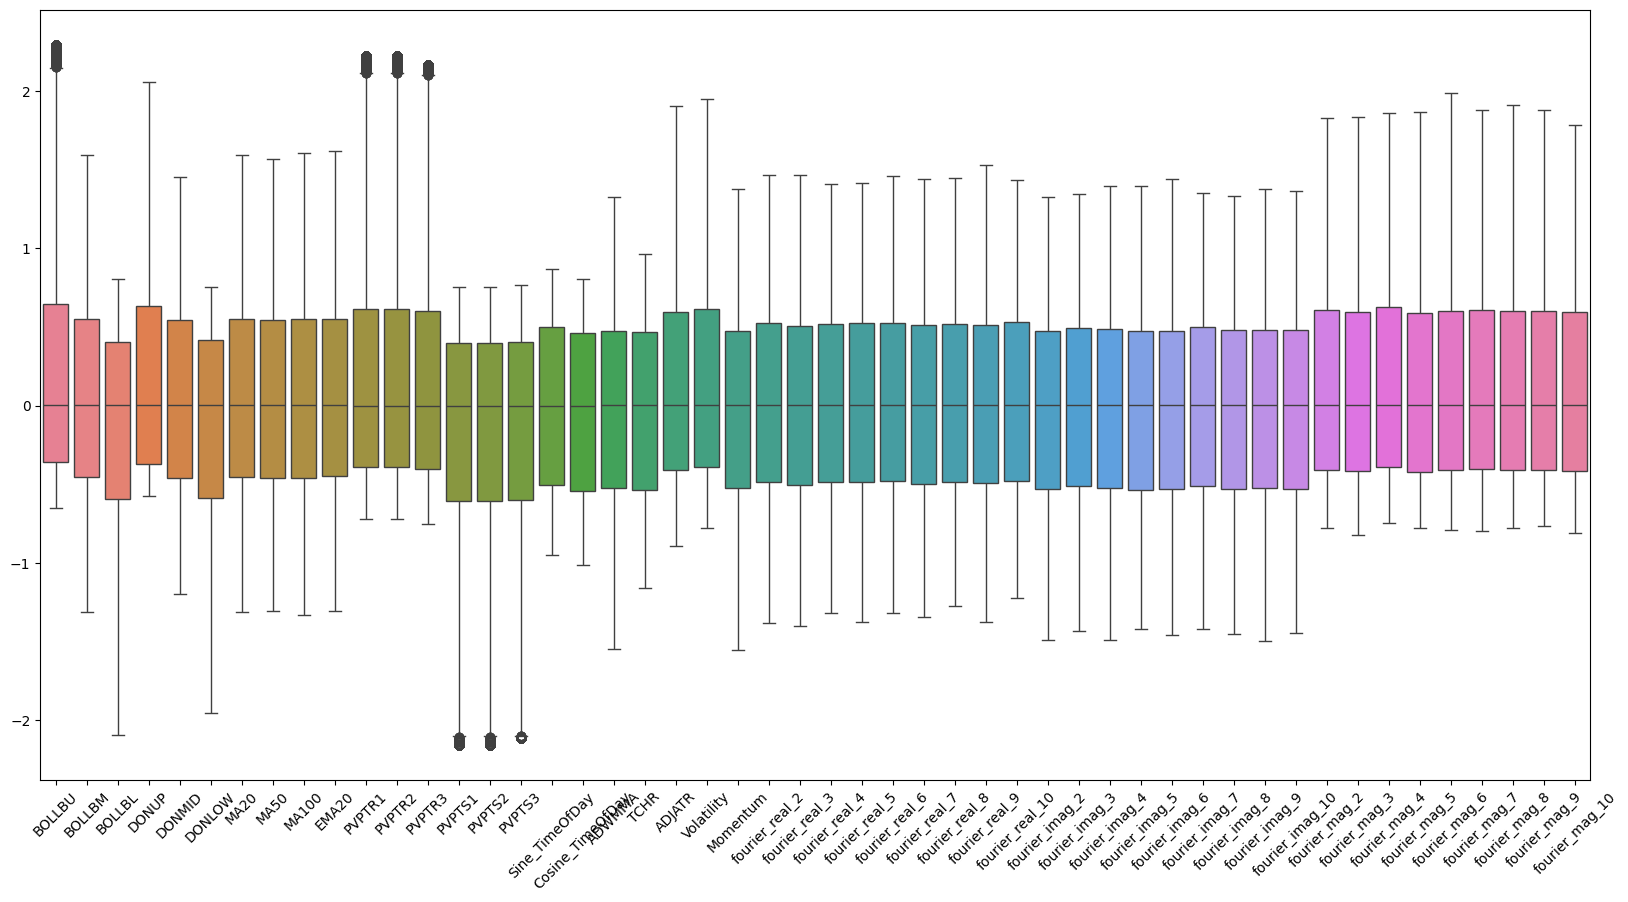

In [27]:
plt.figure(figsize=(20, 10))
sns.boxplot(data=trading_data_scaled[all_training_features])
plt.xticks(rotation=45)
plt.show()

#### UnderSampling and Oversampling Data

In [28]:
do_smote = False
if do_smote:
    epsilon = 0.05

    X = trading_data_scaled[all_training_features]
    y = trading_data_scaled['Close_Slope']

    # Balance dataset by reducing near zero slopes
    extreme_values = trading_data_scaled[np.abs(y) > epsilon]
    near_zero_values = trading_data_scaled[np.abs(y) <= epsilon].sample(frac=0.3, random_state=42)
    balanced_data = pd.concat([extreme_values, near_zero_values]).reset_index(drop=True)
    print(f"Balanced data before smogn shape: {balanced_data.shape}")
    balanced_data['Close_Slope'].describe()
    features_with_labels = all_training_features + ['Close_Slope']
    balanced_data = balanced_data[features_with_labels]

    # Apply SMOGN
    smote_balanced_data = smogn.smoter(
        data=balanced_data, 
        y='Close_Slope', 
        samp_method='balance'
    )
    print(f"Balanced data after smogn shape: {smote_balanced_data.shape}")
    #X_balanced = balanced_data[all_training_features]
    #y_balanced = balanced_data['Close_Slope']

    X = smote_balanced_data[all_training_features]
    y = smote_balanced_data['Close_Slope']

In [29]:
def weighted_loss(preds, dtrain):
    labels = dtrain.get_label()
    residuals = (preds - labels).astype("float")
    weights = np.where(np.abs(labels) > 0.05, 5.0, 1.0)
    grad = 2.0 * residuals * weights
    hess = 2.0 * weights
    return grad, hess

#### Check Weights of buy power and sell power

In [30]:
y = trading_data_scaled[['BuyPower', 'SellPower']]
X = trading_data_scaled[all_training_features]
buying_weight = (y['BuyPower'] > 0).sum() / (y['BuyPower'] == 0).sum()
selling_weight = (y['SellPower'] > 0).sum() / (y['SellPower'] == 0).sum()
print(f"Buying weight: {buying_weight}")
print(f"Selling weight: {selling_weight}")

Buying weight: 0.6222760290556901
Selling weight: 0.4690760623015273


In [31]:
((y['BuyPower'] == 0) & (y['SellPower'] == 0)).sum()

np.int64(5773)

In [32]:
do_weight_balancing = False
if do_weight_balancing:
    epsilon = 0.05
    extreme_values = trading_data_scaled[np.abs(trading_data_scaled['Close_Slope']) > epsilon]
    near_zero_values = trading_data_scaled[np.abs(trading_data_scaled['Close_Slope']) <= epsilon].sample(frac=0.5, random_state=42)
    print(f"Extreme values shape: {extreme_values.shape} and near zero values shape: {near_zero_values.shape}")
    balanced_data = pd.concat([extreme_values, near_zero_values]).reset_index(drop=True)
    print(f"Balanced data shape: {balanced_data.shape} and actual data shape : {trading_data_scaled.shape}")
    X = balanced_data[all_training_features]
    y = balanced_data['Close_Slope']

In [33]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)


In [34]:
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19430 entries, 0 to 19429
Data columns (total 50 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BOLLBU            19430 non-null  float64
 1   BOLLBM            19430 non-null  float64
 2   BOLLBL            19430 non-null  float64
 3   DONUP             19430 non-null  float64
 4   DONMID            19430 non-null  float64
 5   DONLOW            19430 non-null  float64
 6   MA20              19430 non-null  float64
 7   MA50              19430 non-null  float64
 8   MA100             19430 non-null  float64
 9   EMA20             19430 non-null  float64
 10  PVPTR1            19430 non-null  float64
 11  PVPTR2            19430 non-null  float64
 12  PVPTR3            19430 non-null  float64
 13  PVPTS1            19430 non-null  float64
 14  PVPTS2            19430 non-null  float64
 15  PVPTS3            19430 non-null  float64
 16  Sine_TimeOfDay    19430 non-null  float6

In [35]:


#convert data to d matrix to use with xgb
enab_cat = False
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=False )
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=False)

In [36]:
num_boosting_rounds = 20000
##### Implement initial training of the model   
learning_rate = 0.01
starting_tree_method = 'approx'
#metric can be mlogloss, auc, merror etc
metric = 'rmse'

base_params = {
    'objective': 'reg:squarederror',
    'eval_metric': metric,
    'scale_pos_weight': 2.0
}

params = {
    'tree_method': starting_tree_method
}

params.update(base_params)

In [37]:
#model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_boosting_rounds, evals=[(dtrain, 'train')], early_stopping_rounds=50)

In [38]:
##### CReate the objective function for optuna to tune tree parameters

def objective(trial):
    #print("Point 0")
    params = {
        'tree_method' : trial.suggest_categorical('tree_method', ['approx', 'hist']) , 
        'gamma': trial.suggest_float('gamma', 1e-2, 10),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'eta': trial.suggest_float('eta', 0.001, 0.3, log=True),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 250),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_float('lambda', 0.001, 25), 
        'alpha': trial.suggest_float('alpha', 0.001, 10)
    }
    #'scale_pos_weight': trial.suggest_float('scale_pos_weight', min(buying_weight, selling_weight), max(buying_weight, selling_weight))
    params.update(base_params)
    #thresholds = [trial.suggest_float(f'threshold_{i}', 0.1, 0.9) for i in ]
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, f'test-{metric}')
    evals_result = {}
    #print("Point 1")
    #print(dtrain)
    xgb_model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_boosting_rounds, 
                          evals=[(dtest, 'test')],
                          early_stopping_rounds=50,
                          verbose_eval=False,
                          callbacks=[pruning_callback],
                          evals_result=evals_result
                        )
    #print("Point 2")
    preds = xgb_model.predict(dtest)
    rmse_buy = mean_squared_error(y_test['BuyPower'], preds[:, 0]) ** 0.5
    rmse_sell = mean_squared_error(y_test['SellPower'], preds[:, 1]) ** 0.5
    #rmse = np.sqrt(np.mean((preds - y_test.values) ** 2))
    rmse = (rmse_buy + rmse_sell) / 2
    #print("Point 3")
    print(f"Trial {trial.number}: Best iteration = {xgb_model.best_iteration}, test rmse = {rmse}")

    return rmse

In [39]:

study = optuna.create_study(direction='minimize') # for metric auc its maximuze, and for mlogloss its minimie
study.optimize(objective, n_trials=100)

# Get the best parameters
print(f" Best parameters: {study.best_params}")
print(f" Best Accuracy: {study.best_value}")

[I 2025-03-05 09:51:31,258] A new study created in memory with name: no-name-6d05402e-4b9f-4fae-bd42-50c242772108
[I 2025-03-05 09:51:57,656] Trial 0 finished with value: 0.5560105601178513 and parameters: {'tree_method': 'approx', 'gamma': 1.1755704072360227, 'max_depth': 11, 'eta': 0.02023643342970164, 'min_child_weight': 175.3604693056249, 'subsample': 0.5528560467681598, 'colsample_bytree': 0.8057420903844192, 'lambda': 13.603901198165477, 'alpha': 7.188799630146756}. Best is trial 0 with value: 0.5560105601178513.


Trial 0: Best iteration = 6872, test rmse = 0.5560105601178513


[I 2025-03-05 09:52:02,767] Trial 1 finished with value: 0.6205851945069992 and parameters: {'tree_method': 'approx', 'gamma': 3.1126350673964476, 'max_depth': 5, 'eta': 0.03691030534149097, 'min_child_weight': 68.71393991850849, 'subsample': 0.44398358970511803, 'colsample_bytree': 0.9016773930425388, 'lambda': 20.814708620194235, 'alpha': 9.03580281046199}. Best is trial 0 with value: 0.5560105601178513.


Trial 1: Best iteration = 2045, test rmse = 0.6205851945069992


[I 2025-03-05 09:52:06,055] Trial 2 finished with value: 0.6455724745529354 and parameters: {'tree_method': 'approx', 'gamma': 6.762862891435771, 'max_depth': 5, 'eta': 0.010585065758596083, 'min_child_weight': 114.67364750014129, 'subsample': 0.7543770501832244, 'colsample_bytree': 0.6557613118668046, 'lambda': 11.280737598488955, 'alpha': 3.826836343735941}. Best is trial 0 with value: 0.5560105601178513.


Trial 2: Best iteration = 1232, test rmse = 0.6455724745529354


[I 2025-03-05 09:52:13,293] Trial 3 finished with value: 0.6155483731391094 and parameters: {'tree_method': 'hist', 'gamma': 3.9149474115980407, 'max_depth': 12, 'eta': 0.0054946279971658475, 'min_child_weight': 39.57926099917489, 'subsample': 0.876427974715985, 'colsample_bytree': 0.9848747345442526, 'lambda': 15.002022050189659, 'alpha': 9.171704769846311}. Best is trial 0 with value: 0.5560105601178513.


Trial 3: Best iteration = 2069, test rmse = 0.6155483731391094


[I 2025-03-05 09:52:14,485] Trial 4 finished with value: 0.6603761534192263 and parameters: {'tree_method': 'hist', 'gamma': 8.965733952892906, 'max_depth': 8, 'eta': 0.025177019629017784, 'min_child_weight': 119.24415201891291, 'subsample': 0.24144210432752758, 'colsample_bytree': 0.6649635068249284, 'lambda': 9.372393153226316, 'alpha': 8.336686367010907}. Best is trial 0 with value: 0.5560105601178513.
[I 2025-03-05 09:52:14,498] Trial 5 pruned. Trial was pruned at iteration 0.


Trial 4: Best iteration = 677, test rmse = 0.6603761534192263


[I 2025-03-05 09:52:17,524] Trial 6 finished with value: 0.6164733233980979 and parameters: {'tree_method': 'approx', 'gamma': 2.823855685827866, 'max_depth': 4, 'eta': 0.11285191188289251, 'min_child_weight': 212.06526499142285, 'subsample': 0.39678064944270386, 'colsample_bytree': 0.6142387532520779, 'lambda': 12.456631117751627, 'alpha': 1.6647020392798302}. Best is trial 0 with value: 0.5560105601178513.
[I 2025-03-05 09:52:17,530] Trial 7 pruned. Trial was pruned at iteration 0.


Trial 6: Best iteration = 993, test rmse = 0.6164733233980979


[I 2025-03-05 09:52:17,759] Trial 8 pruned. Trial was pruned at iteration 49.
[I 2025-03-05 09:52:28,809] Trial 9 pruned. Trial was pruned at iteration 2120.
[I 2025-03-05 09:52:28,850] Trial 10 pruned. Trial was pruned at iteration 0.
[I 2025-03-05 09:52:28,907] Trial 11 pruned. Trial was pruned at iteration 0.
[I 2025-03-05 09:52:29,520] Trial 12 finished with value: 0.5675816629454999 and parameters: {'tree_method': 'hist', 'gamma': 1.623783812086618, 'max_depth': 10, 'eta': 0.2867638663231071, 'min_child_weight': 1.4732060861671101, 'subsample': 0.9700265969130075, 'colsample_bytree': 0.8794520506859325, 'lambda': 17.426797235221308, 'alpha': 6.8127243835455396}. Best is trial 0 with value: 0.5560105601178513.


Trial 12: Best iteration = 207, test rmse = 0.5675816629454999


[I 2025-03-05 09:52:31,389] Trial 13 finished with value: 0.5715916109106063 and parameters: {'tree_method': 'hist', 'gamma': 1.578805241533618, 'max_depth': 10, 'eta': 0.2827367695499147, 'min_child_weight': 173.5770134170779, 'subsample': 0.6887728748746849, 'colsample_bytree': 0.865164332297595, 'lambda': 18.610839468342924, 'alpha': 6.764084411563583}. Best is trial 0 with value: 0.5560105601178513.


Trial 13: Best iteration = 720, test rmse = 0.5715916109106063


[I 2025-03-05 09:52:31,755] Trial 14 finished with value: 0.5600892959962196 and parameters: {'tree_method': 'hist', 'gamma': 1.3793250328066256, 'max_depth': 10, 'eta': 0.28890613775874296, 'min_child_weight': 5.729825633387037, 'subsample': 0.995405074438767, 'colsample_bytree': 0.7383489321440089, 'lambda': 3.815819071666933, 'alpha': 5.2356163415772}. Best is trial 0 with value: 0.5560105601178513.


Trial 14: Best iteration = 70, test rmse = 0.5600892959962196


[I 2025-03-05 09:52:35,409] Trial 15 finished with value: 0.5397978190859224 and parameters: {'tree_method': 'hist', 'gamma': 0.9073880072390131, 'max_depth': 10, 'eta': 0.10481946131975066, 'min_child_weight': 148.61709799149978, 'subsample': 0.7863159777638584, 'colsample_bytree': 0.7208936547628096, 'lambda': 4.042658290629006, 'alpha': 5.328270408873328}. Best is trial 15 with value: 0.5397978190859224.


Trial 15: Best iteration = 1260, test rmse = 0.5397978190859224


[I 2025-03-05 09:52:35,792] Trial 16 pruned. Trial was pruned at iteration 122.
[I 2025-03-05 09:52:45,081] Trial 17 finished with value: 0.5031884390943875 and parameters: {'tree_method': 'approx', 'gamma': 0.5004569947423265, 'max_depth': 11, 'eta': 0.1117678678427131, 'min_child_weight': 194.2225444469863, 'subsample': 0.613320621535536, 'colsample_bytree': 0.7956906263368045, 'lambda': 5.240884702680176, 'alpha': 5.167035263505248}. Best is trial 17 with value: 0.5031884390943875.


Trial 17: Best iteration = 1664, test rmse = 0.5031884390943875


[I 2025-03-05 09:52:56,507] Trial 18 finished with value: 0.45216360043937864 and parameters: {'tree_method': 'hist', 'gamma': 0.15950169244500334, 'max_depth': 9, 'eta': 0.11374178160406756, 'min_child_weight': 216.53667930403273, 'subsample': 0.6211250644642793, 'colsample_bytree': 0.7031891880201654, 'lambda': 0.8148478581536187, 'alpha': 0.6831345026425986}. Best is trial 18 with value: 0.45216360043937864.
[I 2025-03-05 09:52:56,541] Trial 19 pruned. Trial was pruned at iteration 0.
[I 2025-03-05 09:52:56,572] Trial 20 pruned. Trial was pruned at iteration 0.


Trial 18: Best iteration = 1897, test rmse = 0.45216360043937864


[I 2025-03-05 09:53:01,629] Trial 21 finished with value: 0.5233696136479814 and parameters: {'tree_method': 'hist', 'gamma': 0.7339850672421853, 'max_depth': 11, 'eta': 0.12285093193513298, 'min_child_weight': 206.11599422560184, 'subsample': 0.6552472200470421, 'colsample_bytree': 0.7160361095912053, 'lambda': 5.66296310393871, 'alpha': 4.980884351997231}. Best is trial 18 with value: 0.45216360043937864.


Trial 21: Best iteration = 1460, test rmse = 0.5233696136479814


[I 2025-03-05 09:53:09,329] Trial 22 finished with value: 0.48115586838289703 and parameters: {'tree_method': 'hist', 'gamma': 0.35420667306070497, 'max_depth': 11, 'eta': 0.16463283898737477, 'min_child_weight': 207.11010207318526, 'subsample': 0.6090335517294098, 'colsample_bytree': 0.7730336244673054, 'lambda': 7.110560616591423, 'alpha': 2.461728476677534}. Best is trial 18 with value: 0.45216360043937864.
[I 2025-03-05 09:53:09,359] Trial 23 pruned. Trial was pruned at iteration 0.


Trial 22: Best iteration = 1887, test rmse = 0.48115586838289703


[I 2025-03-05 09:53:09,609] Trial 24 pruned. Trial was pruned at iteration 29.
[I 2025-03-05 09:53:09,631] Trial 25 pruned. Trial was pruned at iteration 0.
[I 2025-03-05 09:53:16,236] Trial 26 finished with value: 0.5020278217159646 and parameters: {'tree_method': 'approx', 'gamma': 0.6458096897244393, 'max_depth': 11, 'eta': 0.1928274672542672, 'min_child_weight': 188.38463203000742, 'subsample': 0.6254118433444421, 'colsample_bytree': 0.9357055414877833, 'lambda': 2.1350631196452703, 'alpha': 2.5234548340050766}. Best is trial 18 with value: 0.45216360043937864.


Trial 26: Best iteration = 1647, test rmse = 0.5020278217159646


[I 2025-03-05 09:53:16,711] Trial 27 pruned. Trial was pruned at iteration 66.
[I 2025-03-05 09:53:16,751] Trial 28 pruned. Trial was pruned at iteration 0.
[I 2025-03-05 09:53:20,103] Trial 29 pruned. Trial was pruned at iteration 770.
[I 2025-03-05 09:53:20,133] Trial 30 pruned. Trial was pruned at iteration 0.
[I 2025-03-05 09:53:25,511] Trial 31 pruned. Trial was pruned at iteration 1310.
[I 2025-03-05 09:53:25,542] Trial 32 pruned. Trial was pruned at iteration 0.
[I 2025-03-05 09:53:25,906] Trial 33 pruned. Trial was pruned at iteration 36.
[I 2025-03-05 09:53:49,185] Trial 34 finished with value: 0.4129444657535727 and parameters: {'tree_method': 'approx', 'gamma': 0.044583640789922455, 'max_depth': 12, 'eta': 0.08415891673918872, 'min_child_weight': 136.36846358046986, 'subsample': 0.7594498252414573, 'colsample_bytree': 0.8412823228736555, 'lambda': 2.564278213869014, 'alpha': 3.1619080567631346}. Best is trial 34 with value: 0.4129444657535727.


Trial 34: Best iteration = 3006, test rmse = 0.4129444657535727


[I 2025-03-05 09:53:52,669] Trial 35 pruned. Trial was pruned at iteration 728.
[I 2025-03-05 09:53:52,703] Trial 36 pruned. Trial was pruned at iteration 0.
[I 2025-03-05 09:53:52,740] Trial 37 pruned. Trial was pruned at iteration 0.
[I 2025-03-05 09:53:52,767] Trial 38 pruned. Trial was pruned at iteration 0.
[I 2025-03-05 09:53:52,802] Trial 39 pruned. Trial was pruned at iteration 0.
[I 2025-03-05 09:53:56,225] Trial 40 pruned. Trial was pruned at iteration 728.
[I 2025-03-05 09:53:56,277] Trial 41 pruned. Trial was pruned at iteration 1.
[I 2025-03-05 09:54:01,681] Trial 42 finished with value: 0.5101015600652081 and parameters: {'tree_method': 'approx', 'gamma': 0.529034059903142, 'max_depth': 12, 'eta': 0.21354055167115654, 'min_child_weight': 198.09838684844064, 'subsample': 0.6270167867459239, 'colsample_bytree': 0.8176815328982466, 'lambda': 5.113124348697044, 'alpha': 5.750989412710721}. Best is trial 34 with value: 0.4129444657535727.


Trial 42: Best iteration = 1116, test rmse = 0.5101015600652081


[I 2025-03-05 09:54:06,519] Trial 43 pruned. Trial was pruned at iteration 1043.
[I 2025-03-05 09:54:06,545] Trial 44 pruned. Trial was pruned at iteration 0.
[I 2025-03-05 09:54:06,566] Trial 45 pruned. Trial was pruned at iteration 0.
[I 2025-03-05 09:54:31,494] Trial 46 finished with value: 0.42670122778911934 and parameters: {'tree_method': 'approx', 'gamma': 0.014891395245848704, 'max_depth': 12, 'eta': 0.215301824147844, 'min_child_weight': 205.4786117658883, 'subsample': 0.6017531381038618, 'colsample_bytree': 0.8630886102645587, 'lambda': 3.2463255679814282, 'alpha': 2.410966229835509}. Best is trial 34 with value: 0.4129444657535727.


Trial 46: Best iteration = 2429, test rmse = 0.42670122778911934


[I 2025-03-05 09:54:32,242] Trial 47 pruned. Trial was pruned at iteration 207.
[I 2025-03-05 09:54:53,398] Trial 48 finished with value: 0.4253525829580549 and parameters: {'tree_method': 'approx', 'gamma': 0.01488447329715827, 'max_depth': 12, 'eta': 0.2387222725450511, 'min_child_weight': 208.17774732959015, 'subsample': 0.6666061704792746, 'colsample_bytree': 0.9603734410764079, 'lambda': 1.6015975982355297, 'alpha': 1.2026585596279338}. Best is trial 34 with value: 0.4129444657535727.
[I 2025-03-05 09:54:53,476] Trial 49 pruned. Trial was pruned at iteration 10.
[I 2025-03-05 09:54:53,499] Trial 50 pruned. Trial was pruned at iteration 0.


Trial 48: Best iteration = 2229, test rmse = 0.4253525829580549


[I 2025-03-05 09:54:55,521] Trial 51 pruned. Trial was pruned at iteration 258.
[I 2025-03-05 09:55:19,074] Trial 52 finished with value: 0.4237536917437833 and parameters: {'tree_method': 'approx', 'gamma': 0.0263802505920656, 'max_depth': 11, 'eta': 0.13897836510249495, 'min_child_weight': 179.61946208618534, 'subsample': 0.5940669033053873, 'colsample_bytree': 0.9741690030710929, 'lambda': 3.690928843071762, 'alpha': 1.4782372390542813}. Best is trial 34 with value: 0.4129444657535727.


Trial 52: Best iteration = 1870, test rmse = 0.4237536917437833


[I 2025-03-05 09:55:46,252] Trial 53 finished with value: 0.4013332275648481 and parameters: {'tree_method': 'approx', 'gamma': 0.01065800546467793, 'max_depth': 10, 'eta': 0.1394889206682504, 'min_child_weight': 176.77611674394547, 'subsample': 0.7047628931542494, 'colsample_bytree': 0.9966322863195164, 'lambda': 4.032262320175688, 'alpha': 1.5223773036096937}. Best is trial 53 with value: 0.4013332275648481.


Trial 53: Best iteration = 2474, test rmse = 0.4013332275648481


[I 2025-03-05 09:55:47,466] Trial 54 pruned. Trial was pruned at iteration 88.
[I 2025-03-05 09:55:47,513] Trial 55 pruned. Trial was pruned at iteration 1.
[I 2025-03-05 09:55:48,933] Trial 56 finished with value: 0.5335796123351983 and parameters: {'tree_method': 'approx', 'gamma': 0.9888212610304131, 'max_depth': 10, 'eta': 0.2979778865103907, 'min_child_weight': 131.17280024649628, 'subsample': 0.7901660425564814, 'colsample_bytree': 0.9774495155737771, 'lambda': 3.085726272668068, 'alpha': 1.1692713375453807}. Best is trial 53 with value: 0.4013332275648481.


Trial 56: Best iteration = 197, test rmse = 0.5335796123351983


[I 2025-03-05 09:55:51,853] Trial 57 finished with value: 0.4968416707112381 and parameters: {'tree_method': 'approx', 'gamma': 0.3629500193322728, 'max_depth': 10, 'eta': 0.2362871736916332, 'min_child_weight': 155.3348178235696, 'subsample': 0.9333383335762689, 'colsample_bytree': 0.9603825928854073, 'lambda': 6.317515583014102, 'alpha': 1.778370839666733}. Best is trial 53 with value: 0.4013332275648481.
[I 2025-03-05 09:55:51,880] Trial 58 pruned. Trial was pruned at iteration 0.
[I 2025-03-05 09:55:51,915] Trial 59 pruned. Trial was pruned at iteration 0.


Trial 57: Best iteration = 679, test rmse = 0.4968416707112381


[I 2025-03-05 09:55:52,698] Trial 60 pruned. Trial was pruned at iteration 77.
[I 2025-03-05 09:55:52,743] Trial 61 pruned. Trial was pruned at iteration 0.
[I 2025-03-05 09:55:55,575] Trial 62 pruned. Trial was pruned at iteration 328.
[I 2025-03-05 09:55:56,245] Trial 63 pruned. Trial was pruned at iteration 85.
[I 2025-03-05 09:55:56,284] Trial 64 pruned. Trial was pruned at iteration 0.
[I 2025-03-05 09:55:56,591] Trial 65 pruned. Trial was pruned at iteration 26.
[I 2025-03-05 09:55:56,636] Trial 66 pruned. Trial was pruned at iteration 0.
[I 2025-03-05 09:55:56,671] Trial 67 pruned. Trial was pruned at iteration 0.
[I 2025-03-05 09:55:56,716] Trial 68 pruned. Trial was pruned at iteration 0.
[I 2025-03-05 09:55:56,780] Trial 69 pruned. Trial was pruned at iteration 4.
[I 2025-03-05 09:56:00,805] Trial 70 finished with value: 0.5033048281295691 and parameters: {'tree_method': 'hist', 'gamma': 0.6990077410186866, 'max_depth': 10, 'eta': 0.18715449886302837, 'min_child_weight': 204.

Trial 70: Best iteration = 996, test rmse = 0.5033048281295691


[I 2025-03-05 09:56:03,671] Trial 71 finished with value: 0.49520902274410483 and parameters: {'tree_method': 'approx', 'gamma': 0.37885704957785243, 'max_depth': 9, 'eta': 0.25140854202825885, 'min_child_weight': 153.15376069050956, 'subsample': 0.940297414212208, 'colsample_bytree': 0.950250763539661, 'lambda': 6.149059474566187, 'alpha': 1.732342933106737}. Best is trial 53 with value: 0.4013332275648481.


Trial 71: Best iteration = 696, test rmse = 0.49520902274410483


[I 2025-03-05 09:56:08,549] Trial 72 finished with value: 0.4789320043808958 and parameters: {'tree_method': 'approx', 'gamma': 0.33311300876229555, 'max_depth': 9, 'eta': 0.24254506180776708, 'min_child_weight': 142.57487018721503, 'subsample': 0.8061056185462813, 'colsample_bytree': 0.9201990141681056, 'lambda': 6.531125694588168, 'alpha': 2.255346675455039}. Best is trial 53 with value: 0.4013332275648481.


Trial 72: Best iteration = 1273, test rmse = 0.4789320043808958


[I 2025-03-05 09:56:09,631] Trial 73 pruned. Trial was pruned at iteration 156.
[I 2025-03-05 09:56:29,703] Trial 74 finished with value: 0.40722555998751697 and parameters: {'tree_method': 'approx', 'gamma': 0.014235397148636295, 'max_depth': 7, 'eta': 0.15963139851829214, 'min_child_weight': 140.28960600198997, 'subsample': 0.7480079811397169, 'colsample_bytree': 0.9096573768179721, 'lambda': 7.236427922581823, 'alpha': 2.9645339580450454}. Best is trial 53 with value: 0.4013332275648481.


Trial 74: Best iteration = 2520, test rmse = 0.40722555998751697


[I 2025-03-05 09:56:30,684] Trial 75 pruned. Trial was pruned at iteration 166.
[I 2025-03-05 09:56:31,233] Trial 76 pruned. Trial was pruned at iteration 59.
[I 2025-03-05 09:56:31,258] Trial 77 pruned. Trial was pruned at iteration 0.
[I 2025-03-05 09:56:31,410] Trial 78 pruned. Trial was pruned at iteration 13.
[I 2025-03-05 09:56:31,441] Trial 79 pruned. Trial was pruned at iteration 0.
[I 2025-03-05 09:56:31,468] Trial 80 pruned. Trial was pruned at iteration 0.
[I 2025-03-05 09:56:36,288] Trial 81 finished with value: 0.47949712274602646 and parameters: {'tree_method': 'approx', 'gamma': 0.38473886791024425, 'max_depth': 11, 'eta': 0.1723848661000581, 'min_child_weight': 133.07475983038972, 'subsample': 0.7146352057585428, 'colsample_bytree': 0.8770673660668522, 'lambda': 7.696726887425883, 'alpha': 2.490790036469867}. Best is trial 53 with value: 0.4013332275648481.
[I 2025-03-05 09:56:36,319] Trial 82 pruned. Trial was pruned at iteration 0.
[I 2025-03-05 09:56:36,354] Trial 83

Trial 81: Best iteration = 812, test rmse = 0.47949712274602646


[I 2025-03-05 09:56:41,092] Trial 84 finished with value: 0.4796820558560308 and parameters: {'tree_method': 'approx', 'gamma': 0.35483787382688214, 'max_depth': 10, 'eta': 0.20825199339290923, 'min_child_weight': 145.52837949274925, 'subsample': 0.7605489567833613, 'colsample_bytree': 0.9021106626872383, 'lambda': 9.794473560697048, 'alpha': 4.215796542616292}. Best is trial 53 with value: 0.4013332275648481.


Trial 84: Best iteration = 1081, test rmse = 0.4796820558560308


[I 2025-03-05 09:56:42,087] Trial 85 pruned. Trial was pruned at iteration 118.
[I 2025-03-05 09:56:42,121] Trial 86 pruned. Trial was pruned at iteration 0.
[I 2025-03-05 09:56:42,155] Trial 87 pruned. Trial was pruned at iteration 0.
[I 2025-03-05 09:56:42,188] Trial 88 pruned. Trial was pruned at iteration 0.
[I 2025-03-05 09:56:44,375] Trial 89 pruned. Trial was pruned at iteration 247.
[I 2025-03-05 09:56:44,410] Trial 90 pruned. Trial was pruned at iteration 0.
[I 2025-03-05 09:56:48,599] Trial 91 pruned. Trial was pruned at iteration 1047.
[I 2025-03-05 09:56:49,623] Trial 92 pruned. Trial was pruned at iteration 167.
[I 2025-03-05 09:56:49,675] Trial 93 pruned. Trial was pruned at iteration 1.
[I 2025-03-05 09:56:50,442] Trial 94 pruned. Trial was pruned at iteration 84.
[I 2025-03-05 09:56:50,472] Trial 95 pruned. Trial was pruned at iteration 0.
[I 2025-03-05 09:56:54,237] Trial 96 finished with value: 0.49415037265592515 and parameters: {'tree_method': 'approx', 'gamma': 0.5

Trial 96: Best iteration = 651, test rmse = 0.49415037265592515
 Best parameters: {'tree_method': 'approx', 'gamma': 0.01065800546467793, 'max_depth': 10, 'eta': 0.1394889206682504, 'min_child_weight': 176.77611674394547, 'subsample': 0.7047628931542494, 'colsample_bytree': 0.9966322863195164, 'lambda': 4.032262320175688, 'alpha': 1.5223773036096937}
 Best Accuracy: 0.4013332275648481


In [40]:
best_params = study.best_params
#best_params
for trial in study.trials:
    print(f"Trial {trial.number}: Best iteration = {trial.user_attrs.get('best_iteration')}, best test rmse = {trial.value}")


Trial 0: Best iteration = None, best test rmse = 0.5560105601178513
Trial 1: Best iteration = None, best test rmse = 0.6205851945069992
Trial 2: Best iteration = None, best test rmse = 0.6455724745529354
Trial 3: Best iteration = None, best test rmse = 0.6155483731391094
Trial 4: Best iteration = None, best test rmse = 0.6603761534192263
Trial 5: Best iteration = None, best test rmse = 0.6692323263134818
Trial 6: Best iteration = None, best test rmse = 0.6164733233980979
Trial 7: Best iteration = None, best test rmse = 0.6692017387789672
Trial 8: Best iteration = None, best test rmse = 0.6552255333262468
Trial 9: Best iteration = None, best test rmse = 0.5853648518092269
Trial 10: Best iteration = None, best test rmse = 0.6692765518392534
Trial 11: Best iteration = None, best test rmse = 0.6690724088809408
Trial 12: Best iteration = None, best test rmse = 0.5675816629454999
Trial 13: Best iteration = None, best test rmse = 0.5715916109106063
Trial 14: Best iteration = None, best test r

In [46]:
low_learning_rate = 0.0326
num_boosting_rounds = 20000
params = {}
params.update(base_params)
params.update(study.best_params)
#params['learning_rate'] = low_learning_rate
params['scale_pos_weight']



2.0

In [47]:
model_stage2 = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_boosting_rounds, 
                         evals=[(dtrain, 'train'), (dtest, 'test')], 
                         early_stopping_rounds=50,
                         verbose_eval=500
                )

[0]	train-rmse:0.64652	test-rmse:0.66555


[500]	train-rmse:0.19209	test-rmse:0.44844
[1000]	train-rmse:0.10178	test-rmse:0.41634
[1500]	train-rmse:0.07645	test-rmse:0.40833
[2000]	train-rmse:0.07042	test-rmse:0.40656
[2500]	train-rmse:0.06791	test-rmse:0.40565
[2764]	train-rmse:0.06703	test-rmse:0.40551


In [48]:
model_stage2.best_iteration # got the best iteration from stage 2 training

2714

In [ ]:
def learning_rate_decay(epoch):
    return 0.1 * (0.99 ** epoch)

#### Set the num boosting 

In [ ]:
num_boosting_rounds = model_stage2.best_iteration

In [49]:
import math

def cosine_decay(current_round, num_boost_round):
    initial_lr = 0.2  # Starting learning rate
    final_lr = 0.01  # Minimum learning rate
    return final_lr + (initial_lr - final_lr) * (1 + math.cos(math.pi * current_round / num_boost_round)) / 2


In [50]:
model_final = xgb.train(params=params, 
                        dtrain=dtrain,
                        num_boost_round = num_boosting_rounds,
                        evals=[(dtest, 'test')],
                        callbacks=[xgb.callback.LearningRateScheduler(lambda current_round: cosine_decay(current_round, num_boosting_rounds))],
                        verbose_eval=100)

[0]	test-rmse:0.66555


[100]	test-rmse:0.53753
[200]	test-rmse:0.49111
[300]	test-rmse:0.46414
[400]	test-rmse:0.44643
[500]	test-rmse:0.43642
[600]	test-rmse:0.42903
[700]	test-rmse:0.42361
[800]	test-rmse:0.41980
[900]	test-rmse:0.41726
[1000]	test-rmse:0.41576
[1100]	test-rmse:0.41484
[1200]	test-rmse:0.41425
[1300]	test-rmse:0.41401
[1400]	test-rmse:0.41362
[1500]	test-rmse:0.41344
[1600]	test-rmse:0.41322
[1700]	test-rmse:0.41310
[1800]	test-rmse:0.41300
[1900]	test-rmse:0.41282
[2000]	test-rmse:0.41274
[2100]	test-rmse:0.41266
[2200]	test-rmse:0.41256
[2300]	test-rmse:0.41243
[2400]	test-rmse:0.41236
[2500]	test-rmse:0.41232
[2600]	test-rmse:0.41229
[2700]	test-rmse:0.41212
[2800]	test-rmse:0.41210
[2900]	test-rmse:0.41203
[3000]	test-rmse:0.41201
[3100]	test-rmse:0.41201
[3200]	test-rmse:0.41200
[3300]	test-rmse:0.41198
[3400]	test-rmse:0.41195
[3500]	test-rmse:0.41194
[3600]	test-rmse:0.41188
[3700]	test-rmse:0.41183
[3800]	test-rmse:0.41172
[3900]	test-rmse:0.41170
[4000]	test-rmse:0.41162
[4100]	te

In [ ]:
#model_path = f'../{config['model_save_name']}'
#model_final.save_model(model_path)

In [51]:
new_data_start_date = pd.to_datetime('2024-01-01')
new_data_end_date = pd.to_datetime('2024-03-30')
new_data = all_trading_data[(all_trading_data['Date'] >= new_data_start_date) & (all_trading_data['Date'] <= new_data_end_date)]
new_data = new_data.reset_index(drop=True)

In [52]:
new_data.shape

(4758, 7)

In [53]:
bolband_period = config['bolband_period']
donchn_period = config['donchn_period']
max_MA_period = 100
max_EMA_period = 20
tchr_period = config['tchr_period']
adwm_period = config['adwm_period']
atr_period = config['atr_period']
volume_ma_period = config['volume_ma_period']
print(f" Fourier window : {fourier_lookback_window}")
max_window = max(bolband_period, 
                 donchn_period, 
                 max_MA_period, 
                 max_EMA_period,
                 tchr_period,
                 adwm_period,
                 atr_period,
                 volume_ma_period, fourier_lookback_window)
print(f"Max window : {max_window}")


 Fourier window : 100
Max window : 100


In [54]:
def process_data(raw_data, scaler):

    trading_signals = pd.DataFrame(columns=['Date','High', 'Low', 'Open', 'Close', 'BuyPower', 'SellPower', 'Signal', 'Take_Profit_Level'])                   
    # This is the dataframe to which we will be adding the rows live
    historical_data = pd.DataFrame(columns=['Date','High', 'Low', 'Open', 'Close', 'Volume'])
    numeric_columns = ['High', 'Low', 'Open', 'Close', 'Volume'] 
    historical_data[numeric_columns] = historical_data[numeric_columns].apply(pd.to_numeric)
    all_training_features = get_all_training_features()
    predictions = []
    for index,row in raw_data.iterrows():

        if index % 100 == 0:
            logging.info(f'Index : {index}')
        new_row = pd.DataFrame({'Date': [row['Date']], 'High': [row['High']], 'Low': [row['Low']], 'Open': [row['Open']], 'Close': [row['Close']], 'Volume': [row['Volume']]})
        signal_row = pd.DataFrame({'Date': [row['Date']], 'High': [row['High']], 'Low': [row['Low']], 'Open': [row['Open']], 'Close': [row['Close']], 'Signal': ['N']})
        trading_signals = pd.concat([trading_signals, signal_row], ignore_index=True)
        historical_data = pd.concat([historical_data, new_row], ignore_index=True)
        historical_data['Volume'] = historical_data['Volume'].astype(int)
        #if len(historical_data) > max_window:
        #    historical_data = historical_data.iloc[-max_window:].reset_index(drop=True)
        if len(historical_data) > max_window:
            #print("Hist data length : ", len(historical_data))
            updated_data = add_new_features_df(historical_data)
            historical_data = historical_data.iloc[-max_window:].reset_index(drop=True)
            #print("Updated data length : ", len(updated_data))
            data_transformed = transform_features(updated_data)
            #print("Data transformed length : ", len(data_transformed))
            #data_transformed = data_transformed.dropna() 
            #data_transformed.reset_index(drop=True, inplace=True)
            inf_features = data_transformed.iloc[-max_window:].reset_index(drop=True)
            #print(f"inf_features shape : {inf_features.shape} and training features : {training_features_upd}")
            #print(inf_features.tail())
            inf_features[all_training_features] = scaler.transform(inf_features[all_training_features])
            last_row_features = inf_features.iloc[[-1]]
            last_row_features = last_row_features[all_training_features]
            if last_row_features.isna().any().any():
                print(f'The inference row at index : {index} contains na')
                print(historical_data[['Volume']].tail())
                break
                continue
        
            last_row_dm = xgb.DMatrix(last_row_features)
            prediction = model_final.predict(last_row_dm)
 
            buy_power, sell_power = prediction[0]
            trading_signals.loc[trading_signals.index[-1], 'BuyPower'] = buy_power
            trading_signals.loc[trading_signals.index[-1], 'SellPower'] = sell_power
            trading_signals.loc[trading_signals.index[-1], 'Take_Profit_Level'] = updated_data['Take_Profit_Level'].iloc[-1]
        
    return trading_signals
    

In [55]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [56]:
tr_signals = process_data(new_data, rscaler)

In [94]:
def calculate_trade(trading_signals):
    trade_positions = []
    #trade_enter_buy = config['trade_enter_buy']
    #trade_enter_sell = config['trade_enter_sell']
    fixed_profit = True
    fixed_profit_value = 1.0
    trade_enter_buy = 0.17
    trade_enter_sell = 0.17
    bar_distance = 300 # in seconds  
    barNo_before_EOD = 20
    min_bar_enter_trade_before_EOD = 14
    EOD_Time = '16:00'
    trades = []
    balance = 0
    profit_amount = 10
    profit_count = 0
    loss_count = 0
    partial_profit_count = 0
    partial_loss_count = 0
    buy_count = 0
    sell_count = 0
    #risk = config['risk']
    risk = 0.16
    loss_amount = profit_amount * risk
    positions = pd.DataFrame(columns=['Entry', 'EntryDate', 'Exit', 'ExitDate', 'Profit', 'Type'])
                    
    for index,row in trading_signals.iterrows():
        buy_power = row['BuyPower']
        sell_power = row['SellPower']
        #print(f'Buy Power : {buy_power}, Sell Power : {sell_power}')

        #predicted_class_index = np.argmax(prob_prediction, axis=1)          #predictions.append(prediction[0])
        

        if len(trades) == 0:
            eod_dt_time = row['Date'].replace(hour=int(EOD_Time.split(':')[0]), minute=int(EOD_Time.split(':')[1]))
            latest_trade_enter_time = eod_dt_time - timedelta(seconds=min_bar_enter_trade_before_EOD * bar_distance)
            if row['Date'] <= latest_trade_enter_time: 
                if buy_power > sell_power and buy_power > trade_enter_buy:
                    if fixed_profit:
                        take_profit = fixed_profit_value
                    else:
                        take_profit = row['Take_Profit_Level'] 
                    trades.append({"Type": "B", 
                                "TakeProfit": row['Close'] + take_profit,
                                "StopLoss": row['Close'] - (take_profit * config['risk']),
                                "Profit": take_profit,
                                "Active": "Y",
                                'Entry': row['Close'],
                                'EntryDate': row['Date']
                                })
                    buy_count += 1
                elif sell_power > buy_power and sell_power > trade_enter_sell:
                    take_profit = row['Take_Profit_Level'] 
                    trades.append({"Type": "S", 
                                "TakeProfit": row['Close'] - take_profit,
                                "Profit": take_profit,
                                "StopLoss": row['Close'] + (take_profit * config['risk']),
                                "Active": "Y",
                                'Entry': row['Close'],
                                'EntryDate': row['Date']
                                })
                    sell_count += 1
        else:
            trade = trades[0]
            eod_dt_time = row['Date'].replace(hour=int(EOD_Time.split(':')[0]), minute=int(EOD_Time.split(':')[1]))
            max_exit_time = eod_dt_time - timedelta(seconds=barNo_before_EOD * bar_distance)
            if row['Date'] >= max_exit_time:
                trade['Active'] = 'N'
                if trade['Type'] == 'B':
                    profit = (row['Close'] - trade['Entry']) * profit_amount
                else:
                    profit = (trade['Entry'] - row['Close']) * profit_amount
                
                if profit < 0:
                    partial_loss_count += 1
                    print(f"EOD Exit , Loss, New Balance : {balance}")
                else:
                    partial_profit_count += 1
                    print(f"EOD Exit, Profit, New Balance : {balance}")
                pos_row = pd.DataFrame({'Entry': [trade['Entry']], 'EntryDate': [trade['EntryDate']], 'Exit': [row['Close']], 'ExitDate': [row['Date']] , 'Profit': profit, 'Type': [trade['Type']]})
                positions = pd.concat([positions, pos_row], ignore_index=True)
            else:
                if buy_power > sell_power and buy_power > trade_enter_buy and trade['Type'] == 'S':
                    trade['Active'] = 'N'
                    profit = (trade['Entry'] - row['Close']) * profit_amount
                    balance += profit 
                    if profit < 0:
                        partial_loss_count += 1
                        print(f"Partial Loss, New Balance : {balance}")
                    else:
                        partial_profit_count += 1
                        print(f"Partial Profit, New Balance : {balance}")
                    pos_row = pd.DataFrame({'Entry': [trade['Entry']], 'EntryDate': [trade['EntryDate']], 'Exit': [row['Close']], 'ExitDate': [row['Date']] , 'Profit': profit, 'Type': [trade['Type']]})
                    positions = pd.concat([positions, pos_row], ignore_index=True)

                elif sell_power > buy_power and sell_power > trade_enter_sell and trades[0]['Type'] == 'B':
                    trade['Active'] = 'N'
                    profit = (row['Close'] - trade['Entry']) * profit_amount
                    balance += profit
                    if profit < 0:
                        partial_loss_count += 1
                        print(f"Partial Loss, New Balance : {balance}")
                    else:
                        partial_profit_count += 1
                        print(f"Partial Profit, New Balance : {balance}")
                    pos_row = pd.DataFrame({'Entry': [trade['Entry']], 'EntryDate': [trade['EntryDate']], 'Exit': [row['Close']], 'ExitDate': [row['Date']] , 'Profit': profit, 'Type': [trade['Type']]})
                    positions = pd.concat([positions, pos_row], ignore_index=True)
        
        
        for trade in trades:
            if (trade['Type'] == 'B' and row['High'] >= trade['TakeProfit']) or (trade['Type'] == 'S' and row['Low'] <= trade['TakeProfit']):
                trade['Active'] = 'N'
                balance += (trade['Profit'] * profit_amount)
                profit_count += 1
                print(f"Take Profit, New Balance : {balance}")             
                pos_row = pd.DataFrame({'Entry': [trade['Entry']], 'EntryDate': [trade['EntryDate']], 'Exit': [row['Close']], 'ExitDate': [row['Date']] , 'Profit': (trade['Profit'] * profit_amount), 'Type': [trade['Type']]})
                positions = pd.concat([positions, pos_row], ignore_index=True)
            elif (trade['Type'] == 'B' and row['Low'] <= trade['StopLoss']) or (trade['Type'] == 'S' and row['High'] >= trade['StopLoss']):
                trade['Active'] = 'N'
                balance -= (trade['Profit'] * loss_amount)
                loss_count += 1
                print(f"Stop Loss, New Balance : {balance}")
                pos_row = pd.DataFrame({'Entry': [trade['Entry']], 'EntryDate': [trade['EntryDate']], 'Exit': [row['Close']], 'ExitDate': [row['Date']] , 'Profit': (trade['Profit'] * -loss_amount), 'Type': [trade['Type']]})
                positions = pd.concat([positions, pos_row], ignore_index=True)


        # Filter out all trades that are not active
        trades = [trade for trade in trades if trade['Active'] == 'Y']
        
    print(f"Final Balance : {balance} \n Take Profit count : {profit_count} \n Stop Loss count : {loss_count} \n Partial Profit count : {partial_profit_count} \n Partial Loss count : {partial_loss_count}")
    print(f"Buy count : {buy_count} \n Sell count : {sell_count}")
    
    return positions


In [95]:
new_data.isna().any(axis=1).sum()

np.int64(0)

In [96]:
new_data.head()

Date Symbol     Open    High     Low   Close   Volume
0 2024-01-02 09:30:00    SPY  472.160  472.80  472.05  472.67  2339778
1 2024-01-02 09:35:00    SPY  472.670  472.74  471.88  471.92  1574945
2 2024-01-02 09:40:00    SPY  471.920  472.10  471.71  471.80  1634708
3 2024-01-02 09:45:00    SPY  471.790  472.09  471.39  471.39  1398881
4 2024-01-02 09:50:00    SPY  471.395  471.95  471.36  471.42  1396561

In [97]:
positions_df = calculate_trade(tr_signals.copy())
#tr_signals.tail()

Partial Loss, New Balance : -1.6499999999996362
Stop Loss, New Balance : -3.2499999999996363
Partial Loss, New Balance : -6.449999999999568
Partial Loss, New Balance : -6.974999999999659
Take Profit, New Balance : 3.0250000000003414
Partial Loss, New Balance : 1.4440000000004378
Stop Loss, New Balance : -0.15599999999956227
Partial Profit, New Balance : 5.794000000000143
Stop Loss, New Balance : 4.194000000000143
EOD Exit , Loss, New Balance : 4.194000000000143
EOD Exit , Loss, New Balance : 4.194000000000143
EOD Exit, Profit, New Balance : 4.194000000000143
Partial Loss, New Balance : -5.7559999999999025
Partial Profit, New Balance : -2.2059999999997206
Partial Loss, New Balance : -8.90599999999988
Partial Loss, New Balance : -10.755999999999903
Partial Profit, New Balance : -8.254999999999585
Partial Loss, New Balance : -10.954999999999972
Stop Loss, New Balance : -12.554999999999971
Partial Profit, New Balance : -11.454999999999835
Partial Profit, New Balance : -9.354999999999471
Pa

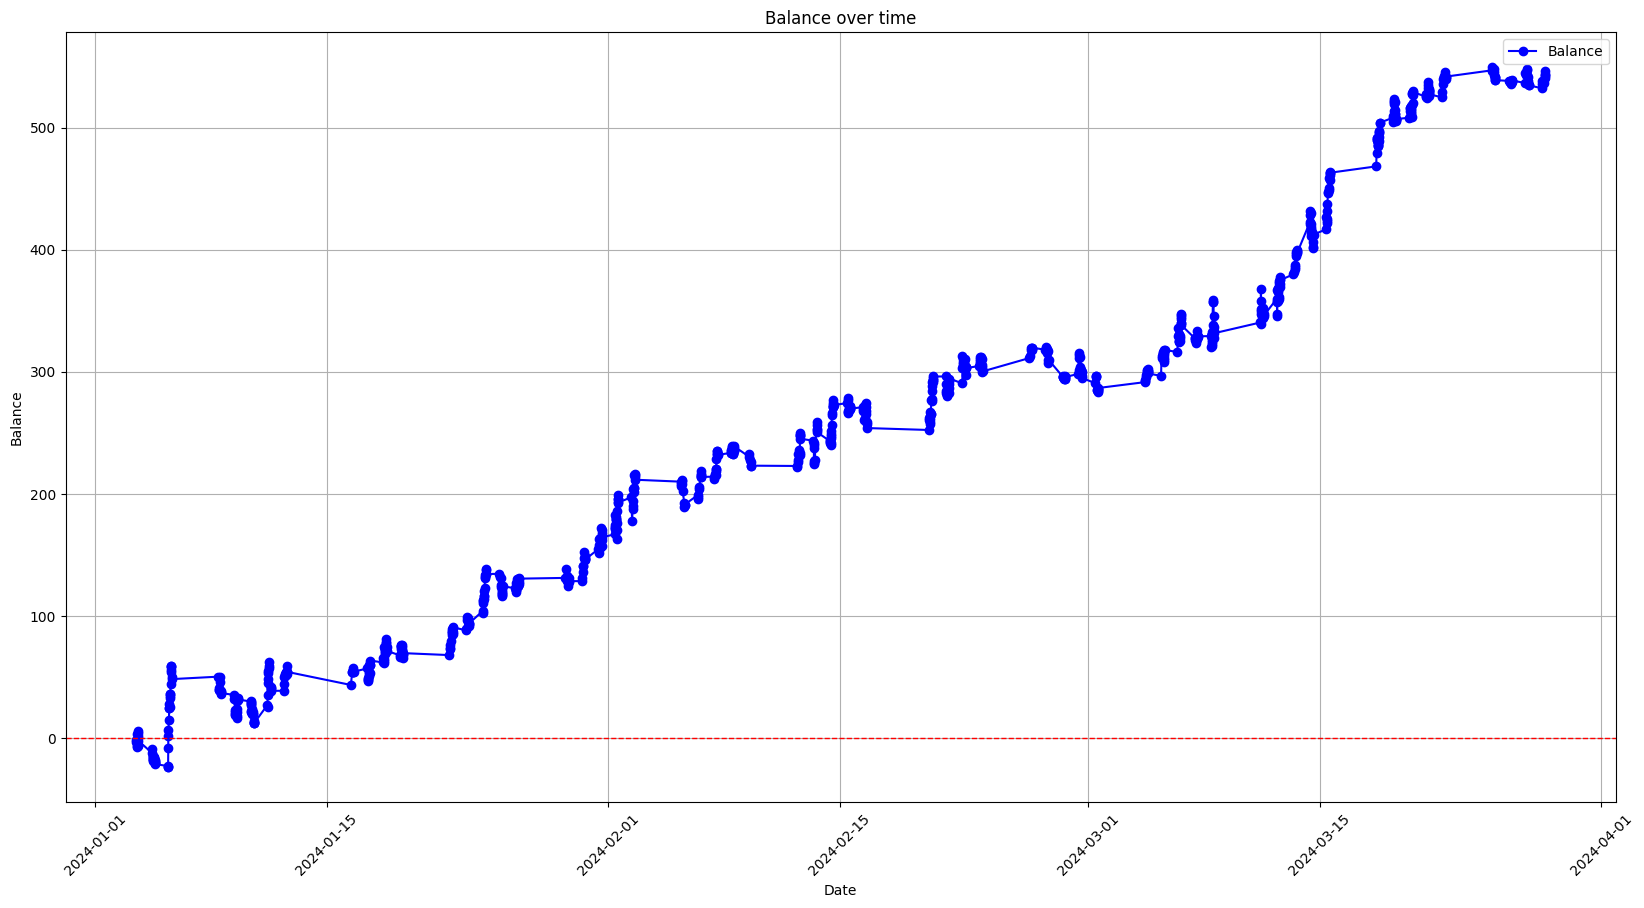

In [98]:
positions_df['ExitDate'] = pd.to_datetime(positions_df['ExitDate'])
positions_df = positions_df.sort_values(by='ExitDate')
positions_df['Balance'] = positions_df['Profit'].cumsum()

plt.figure(figsize=(20, 10))
plt.plot(positions_df['ExitDate'], positions_df['Balance'], marker='o', linestyle='-', color='b', label='Balance')
plt.xlabel('Date')
plt.ylabel('Balance')
plt.title('Balance over time')
plt.axhline(y=0, color='r', linestyle='--', linewidth=1)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [71]:
def calculate_trade_optuna(trading_signals, trading_params):
    trade_positions = []
    #trade_enter_buy = config['trade_enter_buy']
    #trade_enter_sell = config['trade_enter_sell']
    fixed_profit = True
    fixed_profit_value = trading_params['fixed_profit_value']
    trade_enter_buy = trading_params['trade_enter']
    trade_enter_sell = trading_params['trade_enter']
    bar_distance = 300 # in seconds  
    barNo_before_EOD = trading_params['barNo_before_EOD']
    min_bar_enter_trade_before_EOD = trading_params['min_bar_enter_trade_before_EOD']
    risk = trading_params['risk']
    EOD_Time = '16:00'
    trades = []
    balance = 0
    profit_amount = 10
    profit_count = 0
    loss_count = 0
    partial_profit_count = 0
    partial_loss_count = 0
    buy_count = 0
    sell_count = 0
    loss_amount = profit_amount * risk
                    
    for index,row in trading_signals.iterrows():
        buy_power = row['BuyPower']
        sell_power = row['SellPower']
        #print(f'Buy Power : {buy_power}, Sell Power : {sell_power}')

        #predicted_class_index = np.argmax(prob_prediction, axis=1)          #predictions.append(prediction[0])
        

        if len(trades) == 0:
            eod_dt_time = row['Date'].replace(hour=int(EOD_Time.split(':')[0]), minute=int(EOD_Time.split(':')[1]))
            latest_trade_enter_time = eod_dt_time - timedelta(seconds=min_bar_enter_trade_before_EOD * bar_distance)
            if row['Date'] <= latest_trade_enter_time: 
                if buy_power > sell_power and buy_power > trade_enter_buy:
                    if fixed_profit:
                        take_profit = fixed_profit_value
                    else:
                        take_profit = row['Take_Profit_Level'] 
                    trades.append({"Type": "B", 
                                "TakeProfit": row['Close'] + take_profit,
                                "StopLoss": row['Close'] - (take_profit * config['risk']),
                                "Profit": take_profit,
                                "Active": "Y",
                                'Entry': row['Close'],
                                'EntryDate': row['Date']
                                })
                    buy_count += 1
                elif sell_power > buy_power and sell_power > trade_enter_sell:
                    take_profit = row['Take_Profit_Level'] 
                    trades.append({"Type": "S", 
                                "TakeProfit": row['Close'] - take_profit,
                                "Profit": take_profit,
                                "StopLoss": row['Close'] + (take_profit * config['risk']),
                                "Active": "Y",
                                'Entry': row['Close'],
                                'EntryDate': row['Date']
                                })
                    sell_count += 1
        else:
            trade = trades[0]
            eod_dt_time = row['Date'].replace(hour=int(EOD_Time.split(':')[0]), minute=int(EOD_Time.split(':')[1]))
            max_exit_time = eod_dt_time - timedelta(seconds=barNo_before_EOD * bar_distance)
            if row['Date'] >= max_exit_time:
                trade['Active'] = 'N'
                if trade['Type'] == 'B':
                    profit = (row['Close'] - trade['Entry']) * profit_amount
                else:
                    profit = (trade['Entry'] - row['Close']) * profit_amount
                
                if profit < 0:
                    partial_loss_count += 1
                    #print(f"EOD Exit , Loss, New Balance : {balance}")
                else:
                    partial_profit_count += 1
                    #print(f"EOD Exit, Profit, New Balance : {balance}")
            else:
                if buy_power > sell_power and buy_power > trade_enter_buy and trade['Type'] == 'S':
                    trade['Active'] = 'N'
                    profit = (trade['Entry'] - row['Close']) * profit_amount
                    balance += profit 
                    if profit < 0:
                        partial_loss_count += 1
                        #print(f"Partial Loss, New Balance : {balance}")
                    else:
                        partial_profit_count += 1
                        #print(f"Partial Profit, New Balance : {balance}")

                elif sell_power > buy_power and sell_power > trade_enter_sell and trades[0]['Type'] == 'B':
                    trade['Active'] = 'N'
                    profit = (row['Close'] - trade['Entry']) * profit_amount
                    balance += profit
                    if profit < 0:
                        partial_loss_count += 1
                        #print(f"Partial Loss, New Balance : {balance}")
                    else:
                        partial_profit_count += 1
                        #print(f"Partial Profit, New Balance : {balance}")
        
        
        for trade in trades:
            if (trade['Type'] == 'B' and row['High'] >= trade['TakeProfit']) or (trade['Type'] == 'S' and row['Low'] <= trade['TakeProfit']):
                trade['Active'] = 'N'
                balance += (trade['Profit'] * profit_amount)
                profit_count += 1
                #print(f"Take Profit, New Balance : {balance}")             
            elif (trade['Type'] == 'B' and row['Low'] <= trade['StopLoss']) or (trade['Type'] == 'S' and row['High'] >= trade['StopLoss']):
                trade['Active'] = 'N'
                balance -= (trade['Profit'] * loss_amount)
                loss_count += 1
                #print(f"Stop Loss, New Balance : {balance}")


        # Filter out all trades that are not active
        trades = [trade for trade in trades if trade['Active'] == 'Y']
    return balance    
    #print(f"Final Balance : {balance} \n Take Profit count : {profit_count} \n Stop Loss count : {loss_count} \n Partial Profit count : {partial_profit_count} \n Partial Loss count : {partial_loss_count}")
    #print(f"Buy count : {buy_count} \n Sell count : {sell_count}")

In [75]:
def trading_objective(trial):
    params = {
        'trade_enter': trial.suggest_float('trade_enter', 0.1, 2.0),
        'fixed_profit_value': trial.suggest_float('fixed_profit_value', 0.4, 4.0),
        'barNo_before_EOD': trial.suggest_int('barNo_before_EOD', 1, 30),
        'min_bar_enter_trade_before_EOD': trial.suggest_int('min_bar_enter_trade_before_EOD', 5, 30),
        'risk': trial.suggest_float('risk', 0.1, 2.0)
    }

    balance = calculate_trade_optuna(tr_signals, params)

    return balance

In [76]:
trading_study = optuna.create_study(direction='maximize') # for metric auc its maximuze, and for mlogloss its minimie
trading_study.optimize(trading_objective, n_trials=200)

[I 2025-03-05 10:36:05,021] A new study created in memory with name: no-name-0cb633ff-4881-41a2-a8ce-e0ae2ebea199
[I 2025-03-05 10:36:05,136] Trial 0 finished with value: -470.12874673424903 and parameters: {'trade_enter': 1.2459225582693338, 'fixed_profit_value': 1.8577484345168043, 'barNo_before_EOD': 11, 'min_bar_enter_trade_before_EOD': 11, 'risk': 1.5007513136966295}. Best is trial 0 with value: -470.12874673424903.
[I 2025-03-05 10:36:05,234] Trial 1 finished with value: -448.77225239650954 and parameters: {'trade_enter': 0.9448590336559187, 'fixed_profit_value': 0.9774476673055689, 'barNo_before_EOD': 20, 'min_bar_enter_trade_before_EOD': 24, 'risk': 1.6753108839143898}. Best is trial 1 with value: -448.77225239650954.
[I 2025-03-05 10:36:05,338] Trial 2 finished with value: -1547.1034727714007 and parameters: {'trade_enter': 0.2391006871080238, 'fixed_profit_value': 1.2638158802311763, 'barNo_before_EOD': 5, 'min_bar_enter_trade_before_EOD': 15, 'risk': 1.8200496583848154}. Bes

In [77]:
trading_study.best_params

{'trade_enter': 0.10144822203188049,
 'fixed_profit_value': 0.4054052278064447,
 'barNo_before_EOD': 6,
 'min_bar_enter_trade_before_EOD': 11,
 'risk': 0.10271556393588377}

In [78]:
trading_study.best_value

965.3864279914798

In [89]:
def calculate_trade_optuna_2values(trading_signals, trading_params):
    trade_positions = []
    #trade_enter_buy = config['trade_enter_buy']
    #trade_enter_sell = config['trade_enter_sell']
    fixed_profit = True
    fixed_profit_value = trading_params['fixed_profit_value']
    trade_enter_buy = trading_params['trade_enter']
    trade_enter_sell = trading_params['trade_enter']
    bar_distance = 300 # in seconds  
    barNo_before_EOD = trading_params['barNo_before_EOD']
    min_bar_enter_trade_before_EOD = trading_params['min_bar_enter_trade_before_EOD']
    risk = trading_params['risk']
    EOD_Time = '16:00'
    trades = []
    balance = 0
    profit_amount = 10
    profit_count = 0
    loss_count = 0
    partial_profit_count = 0
    partial_loss_count = 0
    buy_count = 0
    sell_count = 0
    loss_amount = profit_amount * risk
    total_trade_length = 0
                    
    for index,row in trading_signals.iterrows():
        buy_power = row['BuyPower']
        sell_power = row['SellPower']
        #print(f'Buy Power : {buy_power}, Sell Power : {sell_power}')

        #predicted_class_index = np.argmax(prob_prediction, axis=1)          #predictions.append(prediction[0])
        

        if len(trades) == 0:
            eod_dt_time = row['Date'].replace(hour=int(EOD_Time.split(':')[0]), minute=int(EOD_Time.split(':')[1]))
            latest_trade_enter_time = eod_dt_time - timedelta(seconds=min_bar_enter_trade_before_EOD * bar_distance)
            if row['Date'] <= latest_trade_enter_time: 
                if buy_power > sell_power and buy_power > trade_enter_buy:
                    if fixed_profit:
                        take_profit = fixed_profit_value
                    else:
                        take_profit = row['Take_Profit_Level'] 
                    trades.append({"Type": "B", 
                                "TakeProfit": row['Close'] + take_profit,
                                "StopLoss": row['Close'] - (take_profit * config['risk']),
                                "Profit": take_profit,
                                "Active": "Y",
                                'Entry': row['Close'],
                                'EntryDate': row['Date']
                                })
            
                    buy_count += 1
                elif sell_power > buy_power and sell_power > trade_enter_sell:
                    take_profit = row['Take_Profit_Level'] 
                    trades.append({"Type": "S", 
                                "TakeProfit": row['Close'] - take_profit,
                                "Profit": take_profit,
                                "StopLoss": row['Close'] + (take_profit * config['risk']),
                                "Active": "Y",
                                'Entry': row['Close'],
                                'EntryDate': row['Date']
                                })
                    sell_count += 1
        else:
            trade = trades[0]
            eod_dt_time = row['Date'].replace(hour=int(EOD_Time.split(':')[0]), minute=int(EOD_Time.split(':')[1]))
            max_exit_time = eod_dt_time - timedelta(seconds=barNo_before_EOD * bar_distance)
            if row['Date'] >= max_exit_time:
                trade['Active'] = 'N'
                if trade['Type'] == 'B':
                    profit = (row['Close'] - trade['Entry']) * profit_amount
                else:
                    profit = (trade['Entry'] - row['Close']) * profit_amount
                
                if profit < 0:
                    partial_loss_count += 1
                    #print(f"EOD Exit , Loss, New Balance : {balance}")
                else:
                    partial_profit_count += 1
                    #print(f"EOD Exit, Profit, New Balance : {balance}")
                trade_time = (pd.to_datetime(row['Date']) -  pd.to_datetime(trade['EntryDate'])) // pd.Timedelta(minutes=5)
                total_trade_length += trade_time
            else:
                if buy_power > sell_power and buy_power > trade_enter_buy and trade['Type'] == 'S':
                    trade['Active'] = 'N'
                    profit = (trade['Entry'] - row['Close']) * profit_amount
                    balance += profit 
                    if profit < 0:
                        partial_loss_count += 1
                        #print(f"Partial Loss, New Balance : {balance}")
                    else:
                        partial_profit_count += 1
                        #print(f"Partial Profit, New Balance : {balance}")

                    trade_time = (pd.to_datetime(row['Date']) -  pd.to_datetime(trade['EntryDate'])) // pd.Timedelta(minutes=5)
                    total_trade_length += trade_time

                elif sell_power > buy_power and sell_power > trade_enter_sell and trades[0]['Type'] == 'B':
                    trade['Active'] = 'N'
                    profit = (row['Close'] - trade['Entry']) * profit_amount
                    balance += profit
                    if profit < 0:
                        partial_loss_count += 1
                        #print(f"Partial Loss, New Balance : {balance}")
                    else:
                        partial_profit_count += 1
                        #print(f"Partial Profit, New Balance : {balance}")
                    trade_time = (pd.to_datetime(row['Date']) -  pd.to_datetime(trade['EntryDate'])) // pd.Timedelta(minutes=5)
                    total_trade_length += trade_time
        
        for trade in trades:
            if (trade['Type'] == 'B' and row['High'] >= trade['TakeProfit']) or (trade['Type'] == 'S' and row['Low'] <= trade['TakeProfit']):
                trade['Active'] = 'N'
                balance += (trade['Profit'] * profit_amount)
                profit_count += 1
                #print(f"Take Profit, New Balance : {balance}")  
                trade_time = (pd.to_datetime(row['Date']) -  pd.to_datetime(trade['EntryDate'])) // pd.Timedelta(minutes=5)
                total_trade_length += trade_time           
            elif (trade['Type'] == 'B' and row['Low'] <= trade['StopLoss']) or (trade['Type'] == 'S' and row['High'] >= trade['StopLoss']):
                trade['Active'] = 'N'
                balance -= (trade['Profit'] * loss_amount)
                loss_count += 1
                #print(f"Stop Loss, New Balance : {balance}")
                trade_time = (pd.to_datetime(row['Date']) -  pd.to_datetime(trade['EntryDate'])) // pd.Timedelta(minutes=5)
                total_trade_length += trade_time


        # Filter out all trades that are not active
        trades = [trade for trade in trades if trade['Active'] == 'Y']
    total_trade_count = buy_count + sell_count
    total_loss_count = loss_count + partial_loss_count
    return balance, total_trade_length / total_trade_count   
    #print(f"Final Balance : {balance} \n Take Profit count : {profit_count} \n Stop Loss count : {loss_count} \n Partial Profit count : {partial_profit_count} \n Partial Loss count : {partial_loss_count}")
    #print(f"Buy count : {buy_count} \n Sell count : {sell_count}")

In [100]:
def trading_objective_2(trial):
    params = {
        'trade_enter': trial.suggest_float('trade_enter', 0.2, 2.0),
        'fixed_profit_value': trial.suggest_float('fixed_profit_value', 0.4, 4.0),
        'barNo_before_EOD': trial.suggest_int('barNo_before_EOD', 1, 30),
        'min_bar_enter_trade_before_EOD': trial.suggest_int('min_bar_enter_trade_before_EOD', 5, 30),
        'risk': trial.suggest_float('risk', 0.1, 2.0)
    }

    balance, trade_length = calculate_trade_optuna_2values(tr_signals, params)

    return balance, trade_length

In [101]:
trading_study_2 = optuna.create_study(directions=['maximize', 'minimize']) # for metric auc its maximuze, and for mlogloss its minimie
trading_study_2.optimize(trading_objective_2, n_trials=200)

[I 2025-03-05 12:17:03,991] A new study created in memory with name: no-name-863dbf79-4fab-48c7-8c87-8e1d6c847aad
[I 2025-03-05 12:17:04,100] Trial 0 finished with values: [44.65204121761262, 29.857142857142858] and parameters: {'trade_enter': 1.8234600225199906, 'fixed_profit_value': 1.4884013739204207, 'barNo_before_EOD': 4, 'min_bar_enter_trade_before_EOD': 6, 'risk': 1.992307203596933}.
[I 2025-03-05 12:17:04,197] Trial 1 finished with values: [-86.20614967670443, 33.6] and parameters: {'trade_enter': 1.7400513332158805, 'fixed_profit_value': 2.389468520061457, 'barNo_before_EOD': 2, 'min_bar_enter_trade_before_EOD': 12, 'risk': 1.5359180497383467}.
[I 2025-03-05 12:17:04,300] Trial 2 finished with values: [327.63441690505385, 23.601626016260163] and parameters: {'trade_enter': 0.8128783991259911, 'fixed_profit_value': 3.541619150554635, 'barNo_before_EOD': 7, 'min_bar_enter_trade_before_EOD': 30, 'risk': 0.14614938645857178}.
[I 2025-03-05 12:17:04,396] Trial 3 finished with value

In [102]:
sorted_trials = sorted(trading_study_2.best_trials, key=lambda t: t.values[0], reverse=True)
for trial in sorted_trials:
    print(f"Trial number : {trial.number}, Balance : {trial.values[0]}, Trade Length : {trial.values[1]}")

Trial number : 52, Balance : 478.59377210835726, Trade Length : 6.725
Trial number : 153, Balance : 452.874607572455, Trade Length : 4.484662576687117
Trial number : 177, Balance : 394.9824674707729, Trade Length : 3.8743654822335025
Trial number : 198, Balance : 390.7712587958589, Trade Length : 3.023877745940783
Trial number : 101, Balance : 357.56369913091663, Trade Length : 3.0216271884654993
Trial number : 122, Balance : 345.19727634431035, Trade Length : 2.998810939357907
Trial number : 197, Balance : 345.19727634431035, Trade Length : 2.998810939357907
Trial number : 152, Balance : 314.71019756869356, Trade Length : 2.3372340425531917
Trial number : 67, Balance : 301.77960588173283, Trade Length : 2.06484375


In [103]:
sorted_trials[0].params

{'trade_enter': 0.5230456997244393,
 'fixed_profit_value': 2.4355406890217037,
 'barNo_before_EOD': 30,
 'min_bar_enter_trade_before_EOD': 25,
 'risk': 0.14614938645857178}

In [82]:
for trial in trading_study_2.trials:
    print(f"Trial {trial.number}: Best value = {trial.values}")

Trial 0: Best value = [420.80199689188004, 263.0]
Trial 1: Best value = [-49.93553682101156, 3.0]
Trial 2: Best value = [-3.7528638737576046, 290.0]
Trial 3: Best value = [132.07973992854397, 85.0]
Trial 4: Best value = [5.487857695356613, 133.0]
Trial 5: Best value = [92.4904572949738, 24.0]
Trial 6: Best value = [-9.453323356199078, 9.0]
Trial 7: Best value = [-233.67029260752417, 232.0]
Trial 8: Best value = [87.99203310314907, 97.0]
Trial 9: Best value = [-247.3006446033359, 189.0]
Trial 10: Best value = [99.58457331213921, 151.0]
Trial 11: Best value = [869.1926460884704, 599.0]
Trial 12: Best value = [164.44383489905508, 203.0]
Trial 13: Best value = [267.63740176036555, 183.0]
Trial 14: Best value = [-180.32554504400116, 158.0]
Trial 15: Best value = [35.414034673272425, 112.0]
Trial 16: Best value = [-599.0375067879481, 556.0]
Trial 17: Best value = [-30.23947556616759, 67.0]
Trial 18: Best value = [-322.7453503622835, 424.0]
Trial 19: Best value = [-39.54070262477896, 6.0]
Tri

In [108]:
def compute_trade_signal(row):
    trade_enter_buy = 0.5
    trade_enter_sell = 0.5
    if row['BuyPower'] > trade_enter_buy and row['BuyPower'] > row['SellPower']:
        return 'B'
    elif row['SellPower'] > trade_enter_sell and row['SellPower'] > row['BuyPower']:
        return 'S'
    else:
        return 'N'
    
tr_signals['SignalNew'] = tr_signals.apply(compute_trade_signal, axis=1)

In [99]:
buy_signals = tr_signals[tr_signals['Signal'] == 'B']
sell_signals = tr_signals[tr_signals['Signal']== 'S']
trade_to_show = '2024-01-05'
#trading_data['Date'] = pd.to_datetime(trading_data['Date'])
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
                    row_heights=[0.7, 0.3], vertical_spacing=0.1,
                    subplot_titles=("CandleStick Chart", "Buy/Sell Signals"))
fig.add_trace(
    go.Candlestick(
        x=tr_signals['Date'], 
        open=tr_signals['Open'], 
        high=tr_signals['High'], 
        low=tr_signals['Low'], 
        close=tr_signals['Close'],
        name='OHLC'
        ), row=1, col=1
)
'''
fig.add_trace(
    go.Scatter(
        x=buy_signals['Date'], 
        y=buy_signals['Low'], 
        mode='markers', 
        name='Buy Signal', 
        marker=dict(color='blue', size=10)))

fig.add_trace(
    go.Scatter(
        x=sell_signals['Date'], 
        y=sell_signals['High'], 
        mode='markers', 
        name='Sell Signal', 
        marker=dict(color='yellow', size=10)))
'''
for index, row in positions_df.iterrows():
    if row['Type'] == 'B':
        entry_symbol = 'triangle-up'
        entry_color = 'blue'
        exit_symbol = 'triangle-down'
        exit_color ='green' if row['Profit'] >= 0 else 'red'
    elif row['Type'] == 'S':
        entry_symbol = 'triangle-down'
        entry_color = 'yellow'
        exit_symbol = 'triangle-up'
        exit_color = 'green' if row['Profit'] >= 0 else 'red'
    
    fig.add_trace(
        go.Scatter(
            x=[row['EntryDate']],
            y=[row['Entry'] + 0.1],
            mode='markers',
            marker=dict(symbol=entry_symbol, size=10, color=entry_color),
            name=f'Entry {row['Type']}'
        ))
    
    fig.add_trace(
        go.Scatter(
            x=[row['ExitDate']],
            y=[row['Exit'] - 0.1],
            mode='markers',
            marker=dict(symbol=exit_symbol, size=10, color=exit_color),
            name=f'Exit {row["Type"]}'
        ))
  
fig.add_trace(
    go.Scatter(
        x=tr_signals['Date'],
        y=tr_signals['BuyPower'],
        mode='lines',
        name='Buy Signal',
        line=dict(color='green', width=2)
    ), row=2, col=1
)

fig.add_trace(
    go.Scatter(
        x=tr_signals['Date'],
        y=tr_signals['SellPower'],
        mode='lines',
        name='Sell Signal',
        line=dict(color='red', width=2)
    ), row=2, col=1
)
  

fig.update_layout(
    title='CandleStick chart with Buy Sell Signals',
    xaxis=dict(type="date", 
               rangebreaks=[
                   dict(bounds=["sat", "mon"]),
                   dict(bounds=[16,9.5], pattern='hour')
               ]              
            ),
    xaxis_rangeslider_visible=False,
    height=600,
    hovermode='x unified'
)



fig.update_xaxes(matches='x')

fig.show()